In [19]:
# Import core libraries
import tensorflow as tf  # Main deep learning framework
from tensorflow import keras  # High-level neural network API
import numpy as np  # Numerical computing library
import matplotlib.pyplot as plt  # Plotting library for visualization

# for evaluation purposes, importing scikit.metric
from sklearn.metrics import confusion_matrix

In [20]:
# new cell 2 for LIF neuron
class LIFNeuron:
    """
    Leaky Integrate-and-Fire neuron implementation.

    This class demonstrates the LIF dynamics before incorporating into layers.
    Paper reference: Appendix A, Equations A.1-A.4
    """

    def __init__(self, tau=20.0, dt=0.25, threshold=0.4, t_ref=1.0):
        """
        Args:
            tau: Membrane time constant (ms) - controls leak rate
            dt: Time step (ms) - discretization step
            threshold: Spike threshold (h_th)
            t_ref: Refractory period (ms) - time after spike when neuron can't fire

        Paper settings (Section B):
            - tau = 20ms
            - dt = 0.25ms
            - threshold = 0.4
            - t_ref = 1ms
        """
        self.tau = tau # the leak rate
        self.dt = dt # time step
        self.threshold = threshold # voltage threshold
        self.t_ref = t_ref # time after the neuron cant fire

        # Calculate leak factor (1 - dt/tau)
        self.alpha = 1.0 - (dt / tau)
        # Calculate input scaling (dt/tau)
        self.beta = dt / tau

        # State variables
        self.v = 0.0  # Membrane potential
        self.ref_count = 0  # Refractory counter (in time steps)

    def step(self, input_current):
        """
        Single time step of LIF dynamics.

        Args:
            input_current: Weighted sum of inputs at this time step

        Returns:
            spike: 1 if neuron fired, 0 otherwise
        """
        spike = 0

        # Check if in refractory period
        if self.ref_count > 0:
            self.ref_count -= 1
            self.v = 0.0  # Keep voltage at 0 during refractory
            return spike

        # Update membrane potential (Equation A.2)
        self.v = self.alpha * self.v + self.beta * input_current

        # Check for spike (Equation A.3)
        if self.v >= self.threshold:
            spike = 1
            self.v = 0.0  # Reset (Equation A.4)
            # Enter refractory period
            self.ref_count = int(self.t_ref / self.dt)
            # we want to wait 1 ms, so we divide the amount of time by the time steps
            # in this particular instance of 1 ms, we would have to wait 4 time steps
            # before this neuron can fire again

        return spike

In [21]:
#initializing fixed random feedback matrices

In [22]:
def compute_weight_stats(num_neurons, v_mean=8.0, v_second_moment=164.0, alpha=0.066):
    """
    Compute weight initialization statistics.
    Paper reference: Appendix C, Equations A.7 and A.8

    Args:
        num_neurons: Number of neurons in layer (N)
        v_mean: Mean input value (v̄)
        v_second_moment: Second moment of input (v̄̄)
        alpha: Constant (0.066)

    Returns:
        w_mean: Mean weight value (W̄_n)
        w_std: Standard deviation (σ_{W_n})
    """
    # Equation A.7: W̄_n = (v̄ - 0.8) / (α · N · v̄)
    w_mean = (v_mean - 0.8) / (alpha * num_neurons * v_mean)

    # Equation A.8: W̄̄_n for computing standard deviation
    numerator = (v_second_moment +
                 alpha**2 * (num_neurons - num_neurons**2) * w_mean**2 * v_mean**2 -
                 1.6 * alpha * num_neurons * v_mean * w_mean -
                 0.64)
    denominator = alpha**2 * num_neurons * v_second_moment

    w_second_moment = numerator / denominator

    # Calculate standard deviation from second moment
    w_std = np.sqrt(w_second_moment - w_mean**2)

    return w_mean, w_std


def initialize_feedback_matrix(output_shape, input_shape,
                                w_mean_next, w_std_next,
                                gamma=0.0338,
                                num_downstream_layers=1):
    """
    Initialize fixed random feedback matrix B.
    Paper reference: Appendix B, Equation A.5

    Args:
        output_shape: Number of neurons this layer projects to
        input_shape: Number of neurons in this layer
        w_mean_next: Mean of weights in next layer
        w_std_next: Std of weights in next layer
        gamma: Scale factor (0.0338 in paper)
        num_downstream_layers: Number of layers between this and output (D)

    Returns:
        B: Fixed random feedback matrix [input_shape, output_shape]
    """
    # Generate random matrix with paper's specific distribution
    # B_n = γ · [W̄_{n+1} + 2√3 · σ_{W_{n+1}} · (rand - 0.5)]

    rand_values = np.random.uniform(0, 1, size=(input_shape, output_shape))

    # Apply paper's formula
    B = w_mean_next + 2 * np.sqrt(3) * w_std_next * (rand_values - 0.5)

    # Apply scaling factor
    B = gamma * B

    # Note: Paper mentions product over downstream layers (∏)
    # For simplicity with 2-layer network, we use single multiplication
    # For deeper networks, you'd multiply B matrices from all downstream layers

    return B.astype(np.float32)




In [23]:
class DFA_LIFLayer(keras.layers.Layer):
    """
    LIF layer with Direct Feedback Alignment (DFA) training.

    This layer implements DFA as described in the paper:
    - Forward: Standard LIF dynamics
    - Backward: DFA error propagation (e_n = [B_n · e] ⊙ f'(a_n))
    """

    def __init__(self, units, output_size,
                 tau=20.0, dt=0.25, threshold=0.4, t_ref=1.0,
                 use_dfa=True, gamma=0.0338,
                 **kwargs):
        """
        Args:
            units: Number of neurons in this layer
            output_size: Number of output neurons (for B matrix shape)
            tau: Membrane time constant (ms)
            dt: Time step (ms)
            threshold: Spike threshold
            t_ref: Refractory period (ms)
            use_dfa: If True, use DFA; if False, use standard BP
            gamma: Scale factor for B initialization
        """
        super().__init__(**kwargs)
        self.units = units
        self.output_size = output_size
        self.tau = tau
        self.dt = dt
        self.threshold = threshold
        self.t_ref = t_ref
        self.use_dfa = use_dfa
        self.gamma = gamma

        # Calculate LIF dynamics parameters
        self.alpha = 1.0 - (dt / tau)  # Leak factor
        self.beta = dt / tau  # Input scaling
        self.ref_steps = int(t_ref / dt)  # Refractory steps

    def build(self, input_shape):
        """
        Build layer weights and feedback matrix.
        """
        input_dim = input_shape[-1]

        # Compute weight initialization statistics (paper's method)
        w_mean, w_std = compute_weight_stats(self.units)

        # Initialize forward weights W (trainable)
        # Using paper's initialization: W = W̄ + 2√3·σ_W·(rand - 0.5)
        w_init = keras.initializers.RandomUniform(
            minval=w_mean - np.sqrt(3) * w_std,
            maxval=w_mean + np.sqrt(3) * w_std
        )

        self.w = self.add_weight(
            name='weights',
            shape=(input_dim, self.units),
            initializer=w_init,
            trainable=True  # W is trained
        )

        # Initialize bias (paper uses 0.8)
        self.b = self.add_weight(
            name='bias',
            shape=(self.units,),
            initializer=keras.initializers.Constant(0.8),
            trainable=True
        )

        if self.use_dfa:
            # Initialize fixed random feedback matrix B (NOT trainable)
            # B projects global error (output_size) to this layer (units)
            w_mean_next, w_std_next = compute_weight_stats(self.output_size)

            B_init = initialize_feedback_matrix(
                output_shape=self.output_size,
                input_shape=self.units,
                w_mean_next=w_mean_next,
                w_std_next=w_std_next,
                gamma=self.gamma
            )

            self.B = self.add_weight(
                name='feedback_matrix',
                shape=(self.units, self.output_size),
                initializer=keras.initializers.Constant(B_init),
                trainable=False  # B is FIXED (never trained)
            )

    def call(self, inputs, training=None):
        """
        Forward pass: LIF dynamics over time.

        Args:
            inputs: [batch, time_steps, input_dim]

        Returns:
            spikes: [batch, time_steps, units]
        """
        batch_size = tf.shape(inputs)[0]
        time_steps_int = inputs.shape[1] # Get Python int for time_steps

        # Initialize state
        v = tf.zeros((batch_size, self.units))  # Membrane potential
        ref_count = tf.zeros((batch_size, self.units))  # Refractory counter

        # Storage for spikes and pre-synaptic currents (needed for DFA)
        spikes_array = tf.TensorArray(
            dtype=tf.float32,
            size=time_steps_int,
            element_shape=(None, self.units)
        )

        # We also need to store pre-activation values (a_n) for gradient
        # In DFA, we compute e_n = [B_n · e] ⊙ f'(a_n)
        # So we need a_n during backward pass

        # Time loop
        for t in range(time_steps_int):
            # Get input at time t
            x_t = inputs[:, t, :]  # [batch, input_dim]

            # Compute input current (v^(t) from Equation A.1)
            i_in = tf.matmul(x_t, self.w) + self.b  # [batch, units]

            # Check refractory period
            not_refractory = tf.cast(ref_count <= 0, tf.float32)

            # Update membrane potential (Equation A.2)
            # Only update if not in refractory period
            v = v * self.alpha + self.beta * i_in
            v = v * not_refractory  # Reset to 0 during refractory

            # Generate spikes (Equation A.3)
            spikes = tf.cast(v >= self.threshold, tf.float32)

            # Reset mechanism (Equation A.4)
            v = v * (1.0 - spikes)  # Set to 0 where spike occurred

            # Update refractory counter
            ref_count = ref_count - 1.0  # Decrement
            ref_count = tf.where(
                spikes > 0,
                tf.ones_like(ref_count) * self.ref_steps,  # Reset to ref period
                ref_count
            )
            ref_count = tf.maximum(ref_count, 0.0)  # Clip at 0

            # Store spikes
            spikes_array = spikes_array.write(t, spikes)

        # Stack spikes: [time_steps, batch, units] → [batch, time_steps, units]
        output_spikes = tf.transpose(spikes_array.stack(), [1, 0, 2])

        # For DFA, we'll handle gradients in a custom training loop
        # For now, return spikes
        return output_spikes

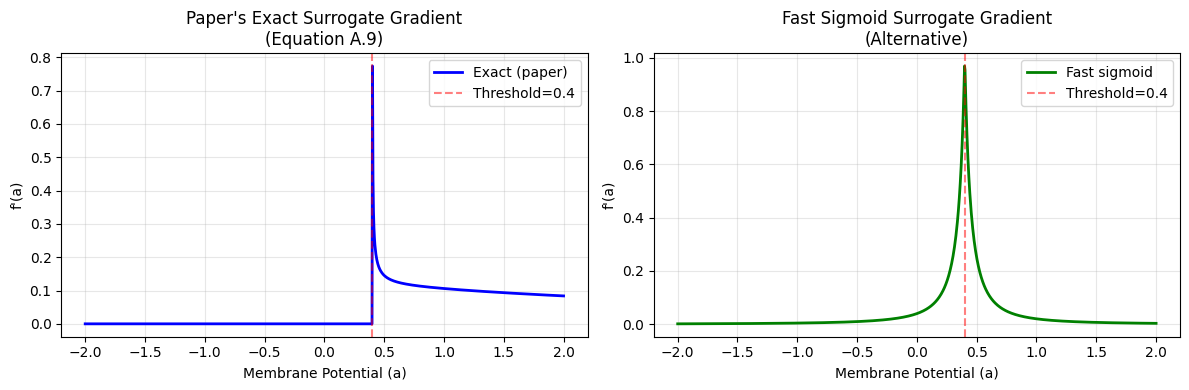

✓ Surrogate gradient functions defined

Note: Both functions are always positive (required for paper's PRFS approach)


In [24]:
def surrogate_gradient_exact(a, h_th=0.4, t_ref=1.0, tau=20.0):
    """
    Exact surrogate gradient from paper (Appendix D, Equation A.9).

    This is the smooth approximation of the Dirac delta function
    that represents the derivative of the LIF spike function.

    Args:
        a: Pre-activation values (membrane potential)
        h_th: Spike threshold
        t_ref: Refractory period (ms)
        tau: Membrane time constant (ms)

    Returns:
        Surrogate gradient f'(a)
    """
    # Only compute gradient where a > threshold
    # (derivative is 0 when a ≤ threshold)

    # Compute ratio a / (a - h_th)
    # Add small epsilon to avoid division by zero
    eps = 1e-8
    ratio = a / (a - h_th + eps)

    # Compute numerator: h_th · t_ref · τ / [a · (a - h_th)]
    numerator = h_th * t_ref * tau / (a * (a - h_th) + eps)

    # Compute denominator: [t_ref + τ · log(ratio)]²
    log_term = tf.math.log(ratio + eps)
    denominator = (t_ref + tau * log_term) ** 2 + eps

    # Compute gradient
    grad = numerator / denominator

    # Only non-zero where a > threshold
    grad = tf.where(a > h_th, grad, tf.zeros_like(grad))

    return grad


def surrogate_gradient_fast_sigmoid(a, threshold=0.4, alpha=10.0):
    """
    Alternative: Fast sigmoid surrogate gradient.

    This is simpler and commonly used in SNN training.
    Formula: 1 / (1 + |alpha * (a - threshold)|)²

    Args:
        a: Pre-activation values
        threshold: Spike threshold
        alpha: Steepness parameter

    Returns:
        Surrogate gradient
    """
    shifted = a - threshold
    grad = 1.0 / (1.0 + tf.abs(alpha * shifted)) ** 2
    return grad


# Visualize both surrogate gradients
a_values = np.linspace(-2, 2, 1000)
threshold = 0.4

# Compute gradients
grad_exact = surrogate_gradient_exact(
    tf.constant(a_values, dtype=tf.float32),
    h_th=threshold
).numpy()

grad_sigmoid = surrogate_gradient_fast_sigmoid(
    tf.constant(a_values, dtype=tf.float32),
    threshold=threshold
).numpy()

# Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(a_values, grad_exact, 'b-', linewidth=2, label="Exact (paper)")
plt.axvline(threshold, color='r', linestyle='--', alpha=0.5, label=f"Threshold={threshold}")
plt.xlabel('Membrane Potential (a)')
plt.ylabel("f'(a)")
plt.title('Paper\'s Exact Surrogate Gradient\n(Equation A.9)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(a_values, grad_sigmoid, 'g-', linewidth=2, label="Fast sigmoid")
plt.axvline(threshold, color='r', linestyle='--', alpha=0.5, label=f"Threshold={threshold}")
plt.xlabel('Membrane Potential (a)')
plt.ylabel("f'(a)")
plt.title('Fast Sigmoid Surrogate Gradient\n(Alternative)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Surrogate gradient functions defined")
print("\nNote: Both functions are always positive (required for paper's PRFS approach)")

In [25]:
import tensorflow as tf # Ensure tf is imported globally for tf.keras
# actual DFA

class DFATrainer:
    """
    Custom trainer implementing Direct Feedback Alignment.

    This replaces the standard backpropagation in model.fit()
    with DFA's direct error injection.
    """

    def __init__(self, model, learning_rate=0.001, use_exact_gradient=True):
        """
        Args:
            model: Keras model with DFA_LIFLayers
            learning_rate: Base learning rate
            use_exact_gradient: If True, use paper's exact f'; else fast sigmoid
        """
        self.model = model
        self.base_lr = learning_rate
        self.use_exact_gradient = use_exact_gradient

        # Get DFA layers (layers with feedback matrix B)
        self.dfa_layers = [
            layer for layer in model.layers
            if isinstance(layer, DFA_LIFLayer) and hasattr(layer, 'B')
        ]

        # Loss function
        self.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

        # Metrics - Explicitly use tf.keras.metrics to avoid any import ambiguities
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_acc = tf.keras.metrics.CategoricalAccuracy(name='train_acc')

    def compute_spike_rate(self, spikes):
        """
        Convert spike trains to rates (for classification).
        Paper uses: output = neuron with highest spike count

        Args:
            spikes: [batch, time, output_dim]

        Returns:
            rates: [batch, output_dim] (sum over time)
        """
        return tf.reduce_sum(spikes, axis=1)  # Sum over time

    def get_layer_learning_rate(self, layer):
        """
        Paper: "Learning rate inversely proportional to input dimension"
        (Section B)

        Args:
            layer: DFA layer

        Returns:
            lr: Adjusted learning rate
        """
        input_dim = layer.w.shape[0]
        return self.base_lr / input_dim

    @tf.function
    def train_step(self, inputs, targets):
        """
        Single DFA training step.

        Implements the DFA algorithm:
        1. Forward pass
        2. Compute global error
        3. Project error to each layer via B
        4. Compute gradients and update weights

        Args:
            inputs: [batch, time, input_dim]
            targets: [batch, output_dim] (one-hot labels)
        """
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]

        # Track intermediate activations for gradient computation
        activations = {}  # Store layer inputs
        pre_activations = {}  # Store pre-synaptic currents (for f')

        with tf.GradientTape(persistent=True) as tape:
            # FORWARD PASS
            # Note: In TensorFlow, we need to manually track intermediate values
            # for custom gradient computation

            current_input = inputs

            for i, layer in enumerate(self.model.layers):
                if isinstance(layer, DFA_LIFLayer):
                    # Store input to this layer (needed for ∂L/∂W = e · x^T)
                    activations[layer.name] = current_input

                    # Store pre-activations (needed for f'(a))
                    # This is the weighted input: a = W^T x + b
                    # We'll compute this during the layer call

                # Forward through layer
                current_input = layer(current_input, training=True)

            # Get final output spikes
            output_spikes = current_input  # [batch, time, output_dim]

            # Convert spikes to rates
            output_rates = self.compute_spike_rate(output_spikes)

            # Normalize to probabilities
            output_probs = tf.nn.softmax(output_rates)

            # Compute loss
            loss = self.loss_fn(targets, output_probs)

        # BACKWARD PASS (DFA)

        # 1. Compute global error at output
        # e_global = prediction - target
        e_global = output_probs - targets  # [batch, output_dim]

        # Expand to match time dimension
        e_global_time = tf.expand_dims(e_global, axis=1)  # [batch, 1, output_dim]
        e_global_time = tf.tile(e_global_time, [1, time_steps, 1])  # [batch, time, output_dim]

        # 2. For each DFA layer, compute gradients
        for layer in reversed(self.dfa_layers):
            # Get feedback matrix B for this layer
            B = layer.B  # [layer_units, output_dim]

            # Project global error through B
            # e_projected = e_global @ B^T
            # Shape: [batch, time, output_dim] @ [output_dim, layer_units]
            #      = [batch, time, layer_units]
            e_projected = tf.matmul(e_global_time, B, transpose_b=True)

            # Get layer input (stored during forward pass)
            layer_input = activations[layer.name]  # [batch, time, input_dim]

            # Compute pre-activation: a = x @ W + b
            a = tf.matmul(layer_input, layer.w) + layer.b
            # Shape: [batch, time, layer_units]

            # Compute surrogate gradient f'(a)
            if self.use_exact_gradient:
                f_prime = surrogate_gradient_exact(a, h_th=layer.threshold)
            else:
                f_prime = surrogate_gradient_fast_sigmoid(a, threshold=layer.threshold)

            # DFA error for this layer: e_n = e_projected ⊙ f'(a)
            e_layer = e_projected * f_prime  # [batch, time, layer_units]

            # Compute weight gradient: ∂L/∂W = (1/T) Σ_t (e^T @ x)
            # For each time step: e_layer[:, t, :] @ layer_input[:, t, :]
            # Average over time and batch

            grad_w = tf.zeros_like(layer.w)
            grad_b = tf.zeros_like(layer.b)

            for t in range(time_steps):
                # Get values at time t
                e_t = e_layer[:, t, :]  # [batch, layer_units]
                x_t = layer_input[:, t, :]  # [batch, input_dim]

                # Gradient for weights: ∂L/∂W = x^T @ e
                # Shape: [input_dim, batch] @ [batch, layer_units]
                #      = [input_dim, layer_units]
                grad_w += tf.matmul(x_t, e_t, transpose_a=True)

                # Gradient for bias: ∂L/∂b = sum over batch
                grad_b += tf.reduce_sum(e_t, axis=0)

            # Average over time and batch
            grad_w = grad_w / (tf.cast(time_steps, tf.float32) * tf.cast(batch_size, tf.float32))
            grad_b = grad_b / (tf.cast(time_steps, tf.float32) * tf.cast(batch_size, tf.float32))

            # Get layer-specific learning rate
            lr = self.get_layer_learning_rate(layer)

            # Update weights: W = W - lr · ∂L/∂W
            layer.w.assign_sub(lr * grad_w)
            layer.b.assign_sub(lr * grad_b)

        # Update metrics
        self.train_loss.update_state(loss)
        self.train_acc.update_state(targets, output_probs)

        return {
            'loss': self.train_loss.result(),
            'accuracy': self.train_acc.result()
        }

    def fit(self, train_data, epochs, verbose=1):
        """
        Train the model using DFA.

        Args:
            train_data: tf.data.Dataset or (x, y) tuple
            epochs: Number of training epochs
            verbose: Verbosity level

        Returns:
            history: Training metrics
        """
        history = {'loss': [], 'accuracy': []}

        for epoch in range(epochs):
            # Reset metrics
            self.train_loss.reset_states()
            self.train_acc.reset_states()

            # Training loop
            if isinstance(train_data, tuple):
                # Simple (x, y) format
                x_train, y_train = train_data
                # Split into batches manually
                batch_size = 32
                num_batches = len(x_train) // batch_size

                for batch_idx in range(num_batches):
                    start_idx = batch_idx * batch_size
                    end_idx = start_idx + batch_size

                    x_batch = x_train[start_idx:end_idx]
                    y_batch = y_train[start_idx:end_idx]

                    metrics = self.train_step(x_batch, y_batch)
            else:
                # tf.data.Dataset format
                for x_batch, y_batch in train_data:
                    metrics = self.train_step(x_batch, y_batch)

            # Record metrics
            loss = float(metrics['loss'])
            acc = float(metrics['accuracy'])
            history['loss'].append(loss)
            history['accuracy'].append(acc)

            if verbose:
                print(f"Epoch {epoch+1}/{epochs} - "
                      f"loss: {loss:.4f} - accuracy: {acc:.4f}")

        return history


In [26]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# One-hot encode labels
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(f"Training samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")
print(f"Input shape: {x_train.shape[1]}")
print(f"Output classes: {y_train.shape[1]}")

# Paper's configuration
TIME_STEPS = 100  # Paper uses 100ms total (simplified from 400 steps)
HIDDEN_SIZE = 1000  # Paper uses 1000 hidden neurons
OUTPUT_SIZE = 10
INPUT_SIZE = 784

# For demo, use smaller dataset
TRAIN_SAMPLES = 1000  # Use 1000 samples for quick demo
x_train_small = x_train[:TRAIN_SAMPLES]
y_train_small = y_train[:TRAIN_SAMPLES]

# Expand to time dimension (paper uses "direct mapping")
# Just repeat the input for each time step
x_train_spikes = np.tile(
    x_train_small[:, np.newaxis, :],  # Add time dim
    (1, TIME_STEPS, 1)  # Repeat TIME_STEPS times
)

print(f"\nInput shape with time: {x_train_spikes.shape}")
print(f"  [batch={x_train_spikes.shape[0]}, "
      f"time={x_train_spikes.shape[1]}, "
      f"features={x_train_spikes.shape[2]}]")

# Build DFA-SNN model
print("\n" + "="*60)
print("BUILDING DFA-SNN MODEL")
print("="*60)

inputs = keras.Input(shape=(TIME_STEPS, INPUT_SIZE))

# Hidden layer with DFA
hidden = DFA_LIFLayer(
    units=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,  # For B matrix initialization
    tau=20.0,
    dt=0.25,
    threshold=0.4,
    t_ref=1.0,
    use_dfa=True,
    gamma=0.0338,
    name='hidden_layer'
)(inputs)

# Output layer (also DFA, but projects to itself)
outputs = DFA_LIFLayer(
    units=OUTPUT_SIZE,
    output_size=OUTPUT_SIZE,
    tau=20.0,
    dt=0.25,
    threshold=0.4,
    t_ref=1.0,
    use_dfa=False,  # Output layer doesn't need B
    name='output_layer'
)(hidden)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

# Create DFA trainer
print("\n" + "="*60)
print("INITIALIZING DFA TRAINER")
print("="*60)

trainer = DFATrainer(
    model=model,
    learning_rate=0.001,  # Base LR (will be adjusted per layer)
    use_exact_gradient=True  # Use paper's exact f'
)

print(f"\nDFA layers found: {len(trainer.dfa_layers)}")
for layer in trainer.dfa_layers:
    lr = trainer.get_layer_learning_rate(layer)
    print(f"  {layer.name}:")
    print(f"    Units: {layer.units}")
    print(f"    B shape: {layer.B.shape}")
    print(f"    Learning rate: {lr:.6f}")

# Train with DFA
print("\n" + "="*60)
print("TRAINING WITH DFA")
print("="*60)
print("\nNote: This is using DIRECT FEEDBACK ALIGNMENT")
print("  - Errors bypass layer-by-layer propagation")
print("  - Each layer receives error directly from output")
print("  - Feedback matrices B are FIXED (not trained)\n")

history = trainer.fit(
    train_data=(x_train_spikes, y_train_small),
    epochs=5,  # Quick demo (paper uses 20)
    verbose=1
)

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (DFA-SNN)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], 'g-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy (DFA-SNN)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ DFA-SNN training complete!")
print(f"\nFinal metrics:")
print(f"  Loss: {history['loss'][-1]:.4f}")
print(f"  Accuracy: {history['accuracy'][-1]:.4f}")
print(f"\nPaper's reported performance (MNIST):")
print(f"  DFA-SNNs: ~96.75% (best), ~92.09% (average)")
print(f"  aDFA-SNNs: ~98.01% (best), ~97.91% (average)")

Training samples: 60000
Test samples: 10000
Input shape: 784
Output classes: 10

Input shape with time: (1000, 100, 784)
  [batch=1000, time=100, features=784]

BUILDING DFA-SNN MODEL


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100, 784)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer (DFA_LIFLayer)     │ (None, 100, 1000)      │       795,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (DFA_LIFLayer)     │ (None, 100, 10)        │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,010 (3.07 MB)

 Trainable params: 795,010 (3.03 MB)

 Non-trainable params: 10,000 (39.06 KB)


INITIALIZING DFA TRAINER

DFA layers found: 1
  hidden_layer:
    Units: 1000
    B shape: (1000, 10)
    Learning rate: 0.000001

TRAINING WITH DFA

Note: This is using DIRECT FEEDBACK ALIGNMENT
  - Errors bypass layer-by-layer propagation
  - Each layer receives error directly from output
  - Feedback matrices B are FIXED (not trained)



AttributeError: 'Mean' object has no attribute 'reset_states'